## NBA Daily Fantasy Sports Points Prediction Model
### (2014-2015 Season)

### Ordinary Least Squares Regression estimator

About the dataset:
* Each row in the dataset is an individual NBA game from an individual player's perspective
* Each NBA game generates ~20 rows in the dataset
  * 1 row for every player that played in that game - each row contains that player's performance in the game  
* DataFrame consists of ~30,000 rows
  * generated from all players/games played in the 2014-2015 NBA regular season  
* DataFrame was generated by scraping http://basketballreference.com 
  * see https://github.com/the212/nba-zerb#data-proceedure 

Abstract:
Using Ordinary Least Squares Regression model on the dataset resulted in a prediction model that was ~4 points closer to the true Fantasy Points production vs. simply using the Average Fantasy Points per season.

This indicates that the dataset's features: 
* Home vs. Away
* Average Mintues Played
* Player's Opponent
* Player's Position

should be taken into account when trying to predict a player's fantasy points production in a future game.

### The data indicates that "Average Minutes Played" is the most important feature in determining a player's fantasy points production. 



In [2]:

import pandas as pd
import numpy as np

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

logs = 'players/2015/logs/alllogs.csv'

games = pd.read_csv(logs)

### Data Munging

Cleanup: 
* Remove players with NaN values
* Home/Away Binary value
* Rename / Drop dataframe columns

In [3]:
games = games.rename(columns={'Unnamed: 5': 'Home'})
games = games.rename(columns={'Unnamed: 7': 'ScoreDiff'})
games = games.drop(['Rk', 'G'], axis=1)

In [4]:
games.Home = games.Home.fillna(value=1)
games.Home = games.Home.replace(to_replace='@', value=0)

### Feature Engineering

New Features:
* Score Difference per game
* Converting all the game data to fantasy points

In [5]:
games['ScoreDiff'] = games.apply(lambda row: (int(str(row['ScoreDiff']).split('(')[1].split(')')[0])), axis=1)

In [6]:
games['fptsFT'] = games.apply(lambda row: (row['FT']), axis=1)
games['fpts2P'] = games.apply(lambda row: (row['FG']*2), axis=1)
games['fpts3P'] = games.apply(lambda row: (row['3P']*3), axis=1)
games['fptsRebounds'] = games.apply(lambda row: (row['TRB']*1.2), axis=1)
games['fptsAssists'] = games.apply(lambda row: (row['AST']*1.5), axis=1)
games['fptsBlocks'] = games.apply(lambda row: (row['BLK']*2), axis=1)
games['fptsSteals'] = games.apply(lambda row: (row['STL']*2), axis=1)
games['fptsTurnovers'] = games.apply(lambda row: (row['TOV']*-1), axis=1)

games['fpts'] = games['fptsFT'] + games['fpts2P'] + games['fptsRebounds'] + games['fptsAssists'] + \
games['fptsBlocks'] + games['fptsSteals'] + games['fptsTurnovers']

In [7]:
n = 'players/2015/names/allnames.csv'
names = pd.read_csv(n)

In [8]:
games = pd.merge(games, names, on='pname', how='outer')

In [9]:
#remove players that have all NaN values - never played game
games = games.dropna(subset=['Date', 'MP', 'Player', 'From', 'To', 'Pos', 'Ht', 'Wt', 'Birth Date', 'College'])

In [10]:
games

,Date,Age,Tm,Home,Opp,ScoreDiff,GS,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,pname,fptsFT,fpts2P,fpts3P,fptsRebounds,fptsAssists,fptsBlocks,fptsSteals,fptsTurnovers,fpts,Player,From,To,Pos,Ht,Wt,Birth Date,College
0,2014-10-29,24-023,NYK,1,CHI,-24,0,21:28,3,6,0.500,0,0,NaN,0,0,NaN,2,4,6,1,0,1,2,4,6,3.4,-15,acyqu01,0,6,0,7.2,1.5,2,0,-2,14.7,Quincy Acy,2013,2016,F,6-7,240,October 6 1990,Baylor University
1,2014-10-30,24-024,NYK,0,CLE,5,1,22:27,4,7,0.571,0,0,NaN,0,0,NaN,6,4,10,2,0,1,2,6,8,7.8,2,acyqu01,0,8,0,12.0,3.0,2,0,-2,23.0,Quincy Acy,2013,2016,F,6-7,240,October 6 1990,Baylor University
2,2014-11-02,24-027,NYK,1,CHO,3,1,20:20,1,4,0.250,0,1,0,0,0,NaN,0,3,3,2,0,0,0,2,2,1.1,11,acyqu01,0,2,0,3.6,3.0,0,0,0,8.6,Quincy Acy,2013,2016,F,6-7,240,October 6 1990,Baylor University
3,2014-11-05,24-030,NYK,0,DET,-3,0,13:42,0,1,0.000,0,0,NaN,0,0,NaN,2,4,6,1,0,1,2,1,0,0.9,-6,acyqu01,0,0,0,7.2,1.5,2,0,-2,8.7,Quincy Acy,2013,2016,F,6-7,240,October 6 1990,Baylor University
4,2014-11-07,24-032,NYK,0,BRK,-11,0,22:14,3,7,0.429,0,0,NaN,1,2,0.500,6,3,9,0,0,0,3,3,7,3.8,-15,acyqu01,1,6,0,10.8,0.0,0,0,-3,14.8,Quincy Acy,2013,2016,F,6-7,240,October 6 1990,Baylor University
5,2014-11-08,24-033,NYK,0,ATL,-7,0,13:34,1,1,1.000,0,0,NaN,0,0,NaN,1,2,3,0,0,0,1,2,2,1.2,-10,acyqu01,0,2,0,3.6,0.0,0,0,-1,4.6,Quincy Acy,2013,2016,F,6-7,240,October 6 1990,Baylor University
6,2014-11-12,24-037,NYK,1,ORL,-2,1,20:12,1,1,1.000,0,0,NaN,0,0,NaN,2,2,4,1,0,0,2,4,2,0.8,-8,acyqu01,0,2,0,4.8,1.5,0,0,-2,6.3,Quincy Acy,2013,2016,F,6-7,240,October 6 1990,Baylor University
7,2014-11-14,24-039,NYK,1,UTA,-2,0,19:39,2,2,1.000,0,0,NaN,2,2,1.000,1,1,2,0,0,0,0,3,6,5.2,-5,acyqu01,2,4,0,2.4,0.0,0,0,0,8.4,Quincy Acy,2013,2016,F,6-7,240,October 6 1990,Baylor University
8,2014-11-16,24-041,NYK,1,DEN,16,1,31:10,3,7,0.429,0,1,0,2,2,1.000,1,7,8,3,3,0,0,3,8,11.0,-3,acyqu01,2,6,0,9.6,4.5,0,6,0,28.1,Quincy Acy,2013,2016,F,6-7,240,October 6 1990,Baylor University
9,2014-11-19,24-044,NYK,0,MIN,-16,1,32:18,4,8,0.500,0,0,NaN,1,1,1.000,2,6,8,0,0,0,3,2,9,4.4,-4,acyqu01,1,8,0,9.6,0.0,0,0,-3,15.6,Quincy Acy,2013,2016,F,6-7,240,October 6 1990,Baylor University


In [11]:
#games.dtypes

In [12]:
games.describe()

,Home,ScoreDiff,GS,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,fptsFT,fpts2P,fpts3P,fptsRebounds,fptsAssists,fptsBlocks,fptsSteals,fptsTurnovers,fpts,From,To,Wt
count,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,21914.000000,23051.000000,23051.000000,15230.000000,23051.000000,23051.000000,13233.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23047.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000,23051.000000
mean,0.502494,-0.034185,0.479979,3.613813,8.155091,0.428763,0.809206,2.300247,0.321137,1.700490,2.230055,0.749508,0.951933,2.964513,3.916446,2.238254,0.779532,0.421240,1.336124,1.917574,9.737322,7.356188,-0.055192,1.700490,7.227626,2.427617,4.699735,3.357381,0.842480,1.559065,-1.336124,18.050653,2010.049889,2015.847859,218.880396
std,0.500005,14.212327,0.499610,2.947878,5.572245,0.231893,1.205427,2.492914,0.305056,2.311174,2.823384,0.285125,1.381168,2.610881,3.420121,2.557720,1.015105,0.835123,1.432739,1.461366,7.851994,7.073600,10.691560,2.311174,5.895756,3.616280,4.104145,3.836580,1.670245,2.030209,1.432739,12.634268,3.919375,0.359165,27.260488
min,0.000000,-53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.500000,-41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000,-3.000000,1998.000000,2015.000000,161.000000
25%,0.000000,-10.000000,0.000000,1.000000,4.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,1.800000,-7.000000,0.000000,2.000000,0.000000,1.200000,0.000000,0.000000,0.000000,-2.000000,8.100000,2008.000000,2016.000000,198.000000
50%,1.000000,-1.000000,0.000000,3.000000,7.000000,0.429000,0.000000,2.000000,0.333000,1.000000,2.000000,0.833000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,1.000000,2.000000,8.000000,6.000000,0.000000,1.000000,6.000000,0.000000,3.600000,1.500000,0.000000,0.000000,-1.000000,16.200000,2011.000000,2016.000000,220.000000
75%,1.000000,10.000000,1.000000,5.000000,12.000000,0.556000,1.000000,4.000000,0.500000,3.000000,4.000000,1.000000,1.000000,4.000000,6.000000,3.000000,1.000000,1.000000,2.000000,3.000000,14.000000,11.600000,6.000000,3.000000,10.000000,3.000000,7.200000,4.500000,2.000000,2.000000,0.000000,26.000000,2013.000000,2016.000000,240.000000
max,1.000000,53.000000,1.000000,21.000000,43.000000,1.000000,11.000000,19.000000,1.000000,22.000000,28.000000,1.000000,15.000000,20.000000,27.000000,20.000000,8.000000,12.000000,11.000000,6.000000,57.000000,48.200000,45.000000,22.000000,42.000000,33.000000,32.400000,30.000000,24.000000,16.000000,0.000000,85.000000,2015.000000,2016.000000,360.000000


### Describe Data - Fun Facts about the 2014-2015 NBA Regular Season / Fantasy Season

Average Player Performance per game:
* Avg FG%: 42%
* Avg 3P%: 32%
* Avg FT%: 75%
* Avg # of Assists: 2.3
* Avg # of Fantasy Points: 18

Extreme Performances:
* Most Fantasy Points scored in a game: 85
* Least Fantasy Points scored in a game: -3

Fun Facts:
* Avg NBA player weight: 218 lbs
* Heaviest NBA player: 360 lbs
* Skinniest NBA player: 161 lbs 

In [13]:
#TODO: look up who these players are
#games.info()

### Feature Engineering Contd.

New Features:
* # Of Weeks in Leauge - removed from model because it yeilded worse results
* Player height (inches)
* Player age
* Season averages from individual game data
  * Minutes Played
  * Fantasy Points
* Dummy variables
  * Opponent
  * Player's Position
  * Player's College - removed from model because it yeilded worse results

In [14]:
import datetime
def convertWeek(date):
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])
    day = int(date.split('-')[2])
    weekNum = datetime.date(year, month, day).isocalendar()[1]
    return weekNum

In [15]:
def convertHt(ht):
    ht = (int(ht.split('-')[0])*12) + int(ht.split('-')[1])
    return ht

In [16]:
games['MP'] = games['MP'].apply(lambda x: int(x.split(':')[0]))
games['Age'] = games['Age'].apply(lambda x: int(x.split('-')[0]))
games['YIL'] = (games['To'] - games['From'])
games['HtInches'] = games['Ht'].apply(convertHt)

#REMOVED weekNum b/c makes model predict slightly worse
#games['weekNum'] = games['Date'].apply(convertWeek)

In [17]:
avgs = games[['pname','MP', 'fpts']]
avgMP = avgs.groupby('pname').mean().reset_index()
avgMP.head()

,pname,MP,fpts
0,acyqu01,18.411765,12.958824
1,aldrico01,15.491803,16.411475
2,allenla01,16.523810,14.065079
3,amundlo01,17.188679,14.558491
4,anderal01,23.067568,12.206757


In [18]:
games = pd.merge(games, avgMP, on='pname', how='outer')

In [19]:
opps = pd.get_dummies(games['Opp'])

In [20]:
pos = pd.get_dummies(games['Pos'])

In [21]:
# REMOVED College dummies b/c makes model predict slightly worse...
#college = pd.get_dummies(games['College'])

In [22]:
#games = pd.concat([games, opps, pos, college], axis=1)
games = pd.concat([games, opps, pos], axis=1)

In [23]:
#games

In [24]:
games = games.drop(['Date', 'Tm', 'Opp', 'ScoreDiff', 'GS', 'MP_x', 'FG', 'FGA', 'FG%', '3P', 
                    '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 
                    'TOV', 'PF', 'PTS', 'GmSc', '+/-', 'pname', 'fptsFT', 'fpts2P', 'fpts3P', 'fptsTurnovers', 
                    'fptsRebounds', 'fptsAssists', 'fptsBlocks', 'fptsSteals', 'Player', 'Wt', 'From', 
                    'To', 'Pos', 'Ht', 'Birth Date', 'College'], 1)

### Final Dataset

In [25]:
games
#fpts_x = target = fantasy points scored that game
#MP_y = avg minutes played per game
#fpts_y = avg fpts per game

,Age,Home,fpts_x,YIL,HtInches,MP_y,fpts_y,ATL,BOS,BRK,CHI,CHO,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS,C,C-F,F,F-C,F-G,G,G-F
0,24,1,14.7,3,79,18.411765,12.958824,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,24,0,23.0,3,79,18.411765,12.958824,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,24,1,8.6,3,79,18.411765,12.958824,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,24,0,8.7,3,79,18.411765,12.958824,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,24,0,14.8,3,79,18.411765,12.958824,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,24,0,4.6,3,79,18.411765,12.958824,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,24,1,6.3,3,79,18.411765,12.958824,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,24,1,8.4,3,79,18.411765,12.958824,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
8,24,1,28.1,3,79,18.411765,12.958824,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,24,0,15.6,3,79,18.411765,12.958824,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Data Visualization

Heatmap of dataset correlation is most revealing visualization.

Visualization clearly illustrates importance of "Minutes Played" in "Fantasy Points" true value

In [26]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/sebsoler1/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


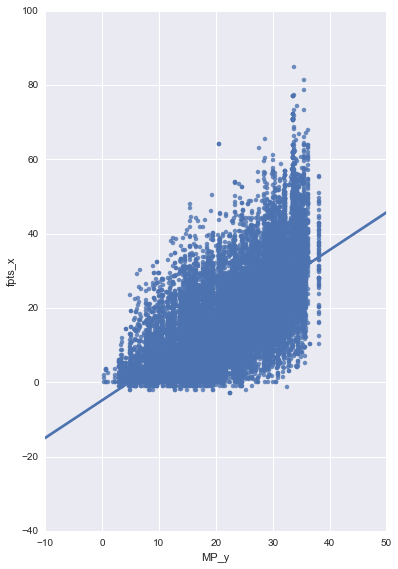

In [27]:
sns.pairplot(games, x_vars=['MP_y'], y_vars='fpts_x', size=8, aspect=0.7, kind='reg')

In [28]:
gamesSimple = games[['Age', 'Home', 'fpts_x', 'YIL', 'HtInches', 'MP_y', 'fpts_y']]
#gamesSimple

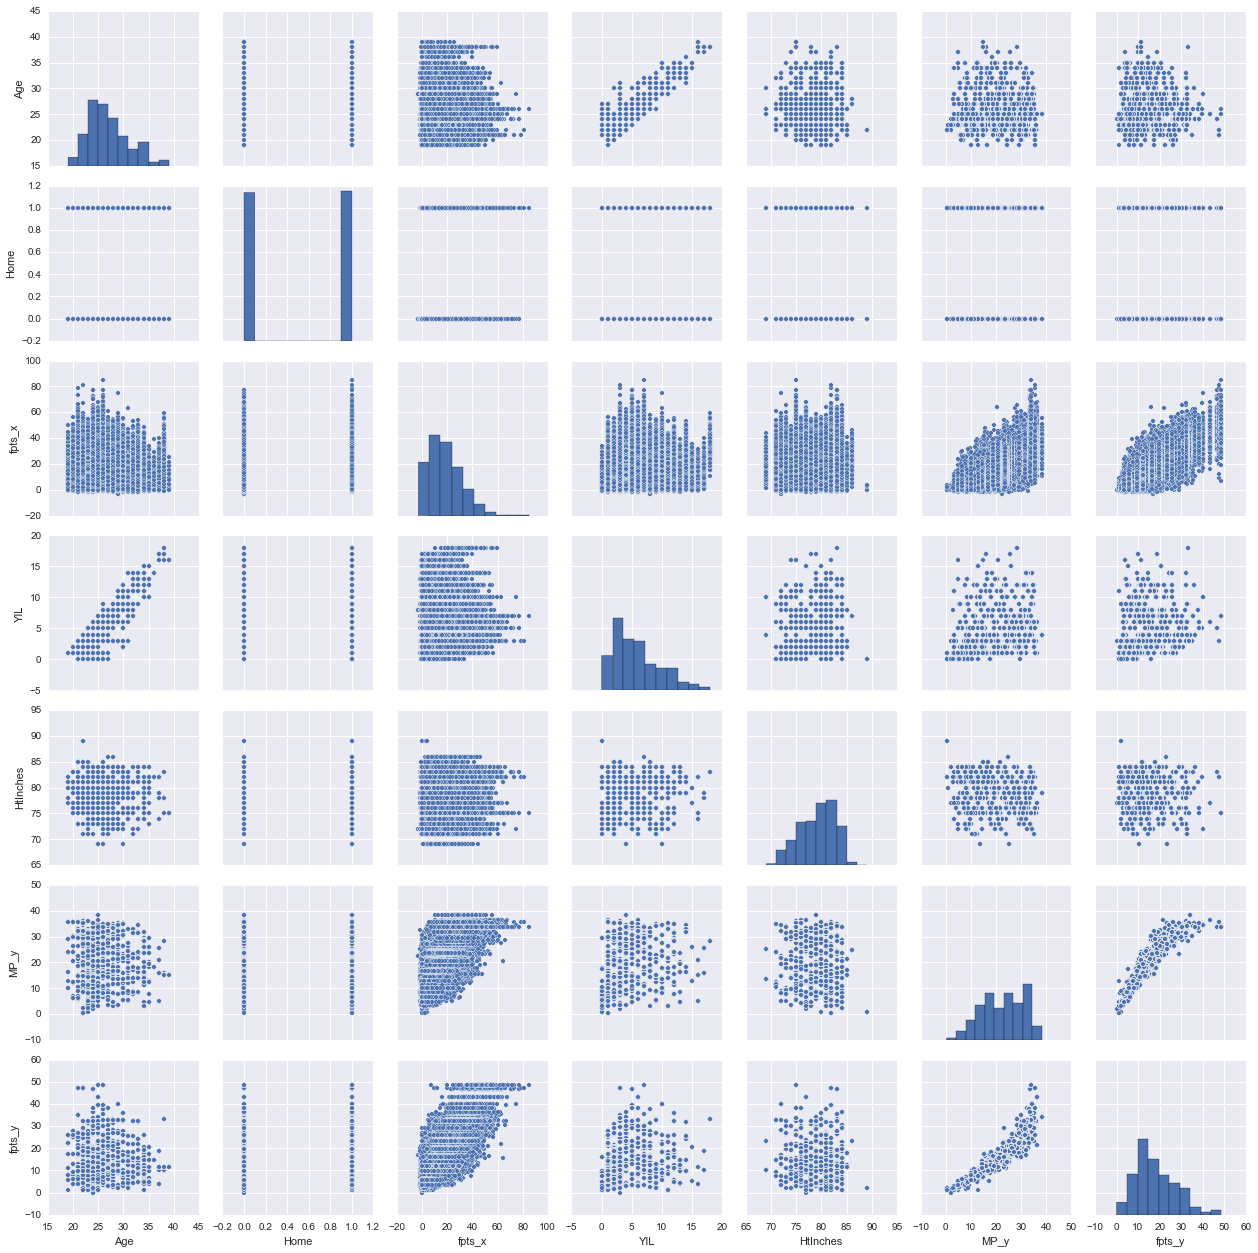

In [29]:
sns.pairplot(gamesSimple)

In [30]:
gamesSimple.corr()

,Age,Home,fpts_x,YIL,HtInches,MP_y,fpts_y
Age,1.000000,0.005921,-0.069081,0.909179,-0.029014,-0.055371,-0.093512
Home,0.005921,1.000000,0.012699,0.005749,-0.006602,0.002996,0.000413
fpts_x,-0.069081,0.012699,1.000000,0.071102,-0.046606,0.660200,0.749196
YIL,0.909179,0.005749,0.071102,1.000000,-0.031208,0.125757,0.094904
HtInches,-0.029014,-0.006602,-0.046606,-0.031208,1.000000,-0.171602,-0.062208
MP_y,-0.055371,0.002996,0.660200,0.125757,-0.171602,1.000000,0.881211
fpts_y,-0.093512,0.000413,0.749196,0.094904,-0.062208,0.881211,1.000000


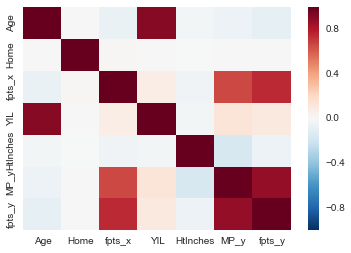

In [31]:
sns.heatmap(gamesSimple.corr())

### Data Visualization takeaways

* Minutes Played most strongly correlated (+) to Fantasy Points
* Years in leage is lightly correlated (+) to Fantasy Points
* Player's height is lightly correlated (-) to Fantasy Points
  * Basically, Point guards on average score more fantasy points than centers... so for your free position fantasy pick, you should not pick a center

In [32]:
## TODO: Feature Selection

### Cross Validation, Train Test Split, and Model Fit

In [33]:
X = games.drop(['fpts_x'], axis=1)
y = games['fpts_x']

In [34]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
print linreg.intercept_
#print linreg.coef_

-0.954432471834


In [38]:
feature_cols = list(games.columns.values)
feature_cols.remove('fpts_x')
feature_cols

zip(feature_cols, linreg.coef_)

[('Age', 0.012633224923239674),
 ('Home', 0.36098884101912482),
 ('YIL', -0.012290281903747464),
 ('HtInches', 0.006708068502855713),
 ('MP_y', -0.0033956675173171247),
 ('fpts_y', 1.0019022247381955),
 ('ATL', 0.28777216045492782),
 ('BOS', 0.80135918350957103),
 ('BRK', 0.042472592426961719),
 ('CHI', 0.33710336051209122),
 ('CHO', 0.26926673825510444),
 ('CLE', -0.32023900644196529),
 ('DAL', -0.33264590671398814),
 ('DEN', 0.78818776864213613),
 ('DET', -0.62224658374272568),
 ('GSW', -0.21153895494635774),
 ('HOU', 0.78582940201448614),
 ('IND', -0.87945874516461853),
 ('LAC', -0.89970476085837814),
 ('LAL', 1.0213194264189143),
 ('MEM', -0.67332971681216303),
 ('MIA', -0.86879275331171457),
 ('MIL', -0.77496012039737439),
 ('MIN', 1.0316217277116611),
 ('NOP', -0.67214197767507067),
 ('NYK', 0.13461888867364771),
 ('OKC', 0.24334120468189191),
 ('ORL', -0.42185870502920503),
 ('PHI', 1.6533130005074623),
 ('PHO', -0.34407824848563184),
 ('POR', 0.28886332376976781),
 ('SAC', 1.13

In [39]:
from sklearn import metrics

### Mean Absolute Error of the model's prediction

In [40]:
y_pred = linreg.predict(X_test)

In [41]:
# this # is how far off your fpts prediction was from true fpts value
print metrics.mean_absolute_error(y_test, y_pred)

6.58182714717


### Compared to DummyRegressor

In [42]:
# TODO: evaluate null model...
from sklearn.dummy import DummyRegressor

In [43]:
dumb = DummyRegressor(strategy='mean')
dumb.fit(X_train, y_train)
y_dumb_pred = dumb.predict(X_test)
print metrics.mean_absolute_error(y_test, y_dumb_pred)
# just taking the avg fpts and guessing gets you 10 pts off from real value vs. 6pts from model

10.2774612634


### Model prediction is ~4 fantasy points better than DummyRegressor

In [44]:
# Just completed Ordinary Least Squares (Linear) Regression

#TODO: run other regression models
# decision tree regressor
# random forest regressor
# knn regressor


In [45]:
# TODO: Grid Search to refine on the best regression model